In [1]:
# https://www.tensorflow.org/tutorials/keras/regression

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os

/home/mattfel/slac/timetool-ML-models/nn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mattfel/slac/timetool-ML-models/nn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mattfel/slac/timetool-ML-models/nn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mattfel/slac/timetool-

1.14.0


Collect data

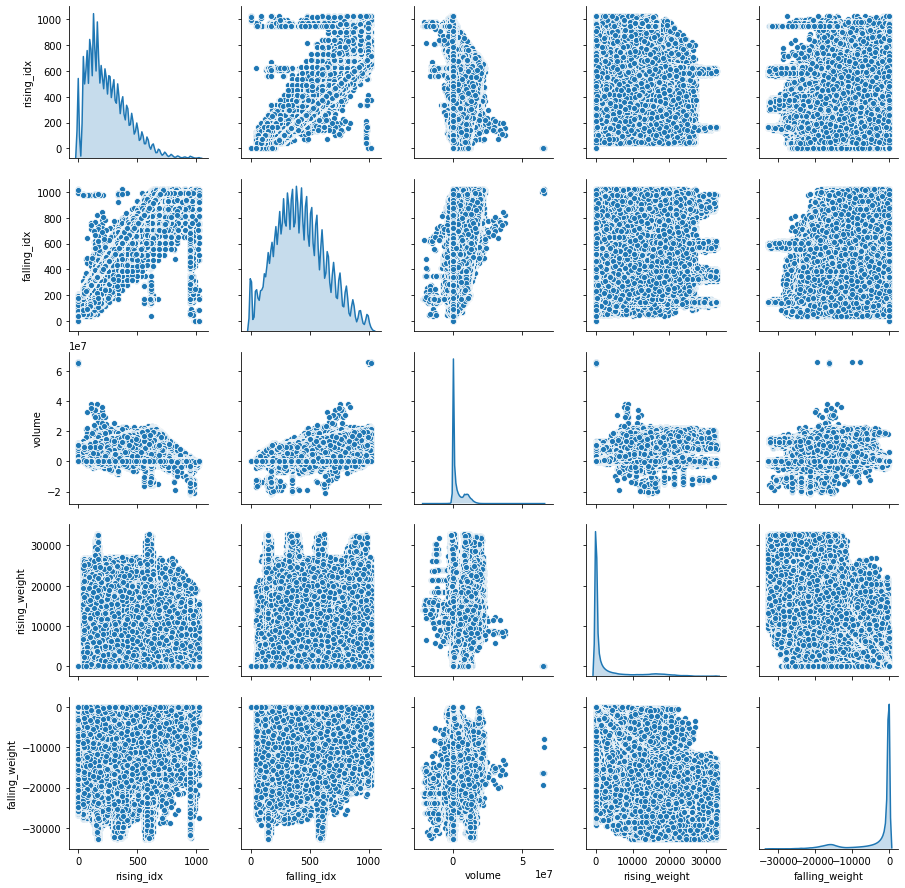

In [2]:


column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'delay']

raw_dataset = pd.read_csv(os.getenv('DATA_FS') + '../preprocessing/processed.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, usecols = column_names[2:])

dataset = raw_dataset.copy()
dataset.tail()

dataset = dataset.dropna()
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["rising_idx", "falling_idx", "volume", "rising_weight", "falling_weight"]], diag_kind="kde")
train_stats = train_dataset.describe()
train_stats.pop("delay")
train_stats = train_stats.transpose()
train_stats
train_labels = train_dataset.pop('delay')
test_labels = test_dataset.pop('delay')





In [3]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
#     layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:

model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:179610.9534,  mean_absolute_error:138.7502,  mean_squared_error:179610.2500,  val_loss:153537.7502,  val_mean_absolute_error:111.2875,  val_mean_squared_error:153537.7188,  
...............

In [ ]:

tf.keras.utils.plot_model(model, to_file='model.png')

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} ns".format(mae))


In [ ]:
from IPython.display import SVG

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True)
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
i = 0
#activation(dot(input, kernel) + bias)
for layer in model.get_weights():
    print('Layer %d' % i)
    print(layer.shape)
    print(layer)
    i =  i + 1